In [1]:
import pickle
with open("vonMisesData.p", "rb") as input_file:
    [NumNeurons, NeuronParameters, WorldParameters, Neurons, 
         NumTrajectories, TrajStartPos, RatRadialSpeed, TrajLength, SpikeRasters] = pickle.load(input_file)

In [2]:
import numpy as np
def BinSpikeRasters(Rasters, BinWidth=0.25, NBins=0) :
    # Rasters is a list of ndarrays, where each array contains spike times for a neuron
    if (NBins == 0) :
        b = 0.0;
        for spk_ts in Rasters :
            if (len(spk_ts) > 0) :
                b = max(b, (spk_ts[-1] / BinWidth))
        NBins = np.int(np.ceil(b))
    BinnedRasters = np.zeros((NBins, len(Rasters)))
    
    for k, spk_ts in enumerate(Rasters) :
        for s in spk_ts :
            BinnedRasters[np.int(s/BinWidth), k] += 1
    return BinnedRasters

In [3]:
import time

t0 = time.time();
# Train model with first environment
bb = BinSpikeRasters(SpikeRasters[0][0])
NTrain = 500
NTest = 500
BinLength = 0.25 # 250 ms bins
NBins = np.int(TrajLength / BinLength)
TrainingData = []
SequenceLengths = []
for w in range(WorldParameters['NEnv']) :
    TrainingData.append(np.zeros((NBins * NTrain, NumNeurons)))
    SequenceLengths.append(np.zeros(NTrain))
    for k in range(NTrain) :
        TrainingData[w][(k*NBins):((k+1)*NBins), :] = BinSpikeRasters(SpikeRasters[w][k])
        SequenceLengths[w][k] = NBins

t1 = time.time();
print(t1-t0)

2.018812894821167


In [4]:
from hmmlearn import hmm
Model = []
NStates = 10
t0 = time.time();
for w in range(WorldParameters['NEnv']) :
    Model.append(hmm.PoissonHMM(n_components=NStates, n_iter=100))
    #Model.append(hmm.GaussianHMM(n_components=NStates, covariance_type='diag', n_iter=100))


for w in range(WorldParameters['NEnv']) :
    t1 = time.time();
    # Build an HMM instance and set parameters
    Model[w].fit(TrainingData[w], lengths=SequenceLengths[w])
    t2 = time.time();
    print(t2-t1)
t3 = time.time();
print(t3-t0) # ~120 s total

13.237623929977417
42.91805386543274
17.195027828216553
21.94605803489685
20.094722986221313
115.39347100257874


/Users/ckemere/anaconda/lib/python3.5/site-packages/hmmlearn-0.2.0-py3.5-macosx-10.5-x86_64.egg/hmmlearn/utils.py:113: RuntimeWarning: divide by zero encountered in log
  log_means = np.where(means > 0, np.log(means), 0)
/Users/ckemere/anaconda/lib/python3.5/site-packages/hmmlearn-0.2.0-py3.5-macosx-10.5-x86_64.egg/hmmlearn/utils.py:113: RuntimeWarning: invalid value encountered in log
  log_means = np.where(means > 0, np.log(means), 0)


/Users/ckemere/anaconda/lib/python3.5/site-packages/hmmlearn-0.2.0-py3.5-macosx-10.5-x86_64.egg/hmmlearn/utils.py:113: RuntimeWarning: divide by zero encountered in log
  log_means = np.where(means > 0, np.log(means), 0)


-5114.432456682006

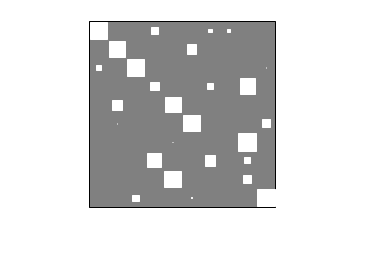

In [5]:
import bayespy.plot as bpplt
%matplotlib inline
bpplt.pyplot.figure()


bpplt.hinton(Model[1].transmat_)

bs = BinSpikeRasters(SpikeRasters[0][501])
Model[0].score(bs)


In [6]:
SequenceLL = []
t1 = time.time();
for w in range(WorldParameters['NEnv']) :
    SequenceLL.append(np.zeros(NTest))
    
for w in range(WorldParameters['NEnv']) :
    for i in range(NTest) :
        SequenceLL[w][i] = Model[0].score(BinSpikeRasters(SpikeRasters[w][NTrain + i]))
    t2 = time.time();
    print(t2-t1)


0.7265050411224365
1.3476788997650146
1.9960079193115234
2.698058843612671
3.441776990890503


/Users/ckemere/anaconda/lib/python3.5/site-packages/hmmlearn-0.2.0-py3.5-macosx-10.5-x86_64.egg/hmmlearn/utils.py:113: RuntimeWarning: divide by zero encountered in log
  log_means = np.where(means > 0, np.log(means), 0)


In [7]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# display place field coverage of a particular environment
sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")

/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


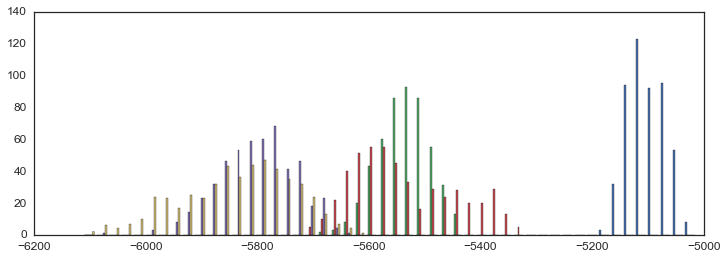

In [8]:
plt.hist(SequenceLL,bins=50);